In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def adjust_image(im):
    imgs = im.resize((299, 299), Image.ANTIALIAS)
    return imgs

In [6]:
import os
from PIL import Image
import numpy as np
import random
import glob

X=[]
X_processed=[]
Y=[]


classes = {"TCGA-LUAD": 0, "TCGA-LUSC": 1}

path = "/home/shared/stanford/cs231n/project/tcga_patches/"
converted_files = "/home/amir/project/pytorch-CycleGAN-and-pix2pix/tcga_lung_LUSC/all_stain_cyclegan/test_1/images/"

for directory in os.listdir(path):
    for file in os.listdir(path + directory)[:10000]:
        converted_file = converted_files + file[:-4] + "_fake_B.png"        
        if(os.path.exists(converted_file)):
            img=Image.open(path + directory + "/" + file).convert("RGB")
            img = adjust_image(img)
            features=np.array(img, dtype=np.float32)/255.0
            processed_img = Image.open(converted_file)
            processed_img = adjust_image(processed_img)
            processed_feature=np.array(processed_img, dtype=np.float32)/255.0
            X_processed.append(processed_feature)
            X.append(features)
            Y.append(classes[directory])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_processed_train, X_processed_test, y_processed_train, y_processed_test = train_test_split(X_processed, Y, test_size=0.33, random_state=42)

X_processed_train = np.array(X_processed_train)
X_processed_test = np.array(X_processed_test)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [8]:
np.bincount(y_train)

array([ 417, 1339])

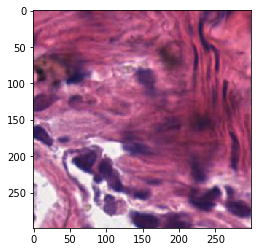

In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_train[10])

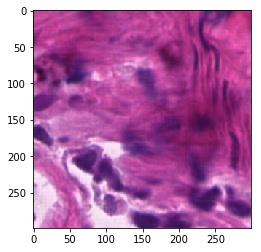

In [9]:
plt.imshow(X_processed_train[10])

In [10]:
NUM_CLASSES = 2

def inceptionv3_model_fn(features, labels, mode):
    # Load Inception-v3 model.
    module = hub.Module("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1")
    input_layer = features["x"]
    outputs = module(input_layer)
    logits = tf.layers.dense(inputs=outputs, units=NUM_CLASSES)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    accuracy = tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])
    tf.summary.scalar("accuracy", accuracy[1])
    
    

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Set up logging for predictions
    tensors_to_log = {"accuracy": accuracy[1]}
    logging_hook = tf.train.LoggingTensorHook(
        tensors=tensors_to_log, every_n_iter=100)
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op, training_hooks=[logging_hook])

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": accuracy}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



def run_graph(X_train_, y_train_, X_test_, y_test_, log_dir, epochs):
    with tf.Graph().as_default() as g:
            # create input functions for train and evaluate methods.
            train_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": X_train_},
                y=y_train_,
                batch_size=40,
                num_epochs=None,
                shuffle=True)
            eval_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": X_test_},
                y=y_test_,
                num_epochs=1,
                shuffle=False)

            # Create an estimator
            classifier = tf.estimator.Estimator(
                model_fn=inceptionv3_model_fn, model_dir=log_dir)
            
            for i in range(epochs):
                print("Epoc %i..." % i)
                # Train network.
                classifier.train(
                    input_fn=train_input_fn,
                    steps=200)

                # Evaluate the model and print results.
                eval_results = classifier.evaluate(input_fn=eval_input_fn)

#run_graph(X_train, y_train, X_test, y_test, "lung_classification", 50)
run_graph(X_processed_train, y_train, X_processed_test, y_test, "lung_classification_processed", 25)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'lung_classification_processed', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9a3eed3e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Epoc 0...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'.
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_1a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

KeyboardInterrupt: 